# Voice-Driven Disease Classification: A Deep Learning Approach


In [1]:
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import TensorDataset, DataLoader


import os
from tqdm import tqdm
import IPython.display as ipd
from wordcloud import WordCloud


import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from speech_to_text import speech_to_text

from model.classifier import Classifier
from model.conv_net import M5
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

%load_ext autoreload
%autoreload 2

In [2]:
record_df = pd.read_csv("./data/overview-of-recordings.csv")

# print the number of recordings
print("Number of recordings: ", len(record_df))
print("Number of features: ", len(record_df.columns))

Number of recordings:  6661
Number of features:  14


In [3]:
# check if we have the same number of audio files (.wav) as we have rows in the dataframe
data_dir = "./data/recordings"
nb_training_samples = len(os.listdir(os.path.join(data_dir, "train")))
nb_validation_samples = len(os.listdir(os.path.join(data_dir, "validate")))
nb_test_samples = len(os.listdir(os.path.join(data_dir, "test")))
print("Number of training samples: ", nb_training_samples)
print("Number of validation samples: ", nb_validation_samples)
print("Number of test samples: ", nb_test_samples)
print("Total number of samples: ", nb_training_samples + nb_test_samples + nb_validation_samples)


Number of training samples:  5895
Number of validation samples:  385
Number of test samples:  381
Total number of samples:  6661


### Add a column to indicate if the record is in the training set, validation set, or test set 


In [4]:
train_files = set(os.listdir(os.path.join(data_dir, "train")))
valid_files = set(os.listdir(os.path.join(data_dir, "validate")))
test_files = set(os.listdir(os.path.join(data_dir, "test")))

record_df["split"] = record_df["file_name"].apply(lambda x: "train" if x in train_files else ("validate" if x in valid_files else "test"))

# check if the numbers corresponds to the previous numbers
print("Number of training samples: ", len(record_df[record_df.split == "train"]))
print("Number of validation samples: ", len(record_df[record_df.split == "validate"]))
print("Number of test samples: ", len(record_df[record_df.split == "test"]))


Number of training samples:  5895
Number of validation samples:  385
Number of test samples:  381


In [5]:
# save the record df 
record_df.to_csv("./data/overview-of-recordings2.csv", index=False)

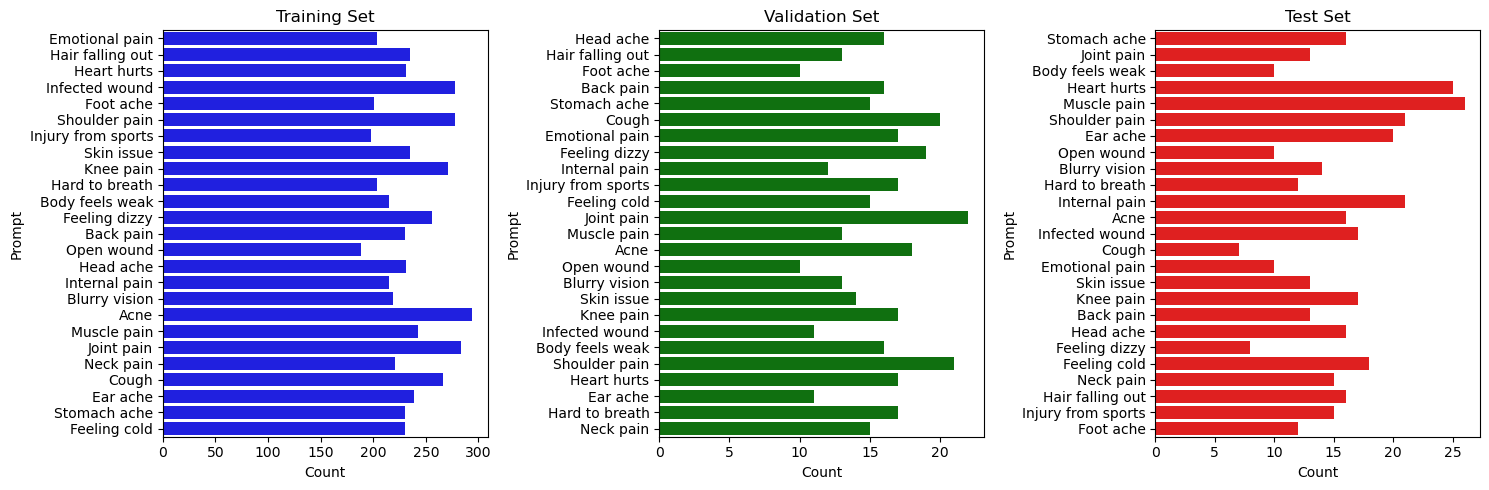

In [6]:
# Filter data for each split
train_df = record_df[record_df['split'] == 'train']
valid_df = record_df[record_df['split'] == 'validate']
test_df = record_df[record_df['split'] == 'test']

# Create Seaborn count plot
def create_count_plot(ax, df, title, color):
    sns.countplot(y='prompt', data=df, color=color, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Count')
    ax.set_ylabel('Prompt')

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figure size as needed

# Combine the count plots on the same row
create_count_plot(axes[0], train_df, 'Training Set', 'blue')
create_count_plot(axes[1], valid_df, 'Validation Set', 'green')
create_count_plot(axes[2], test_df, 'Test Set', 'red')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


### Create a word cloud for all the classes in the training set


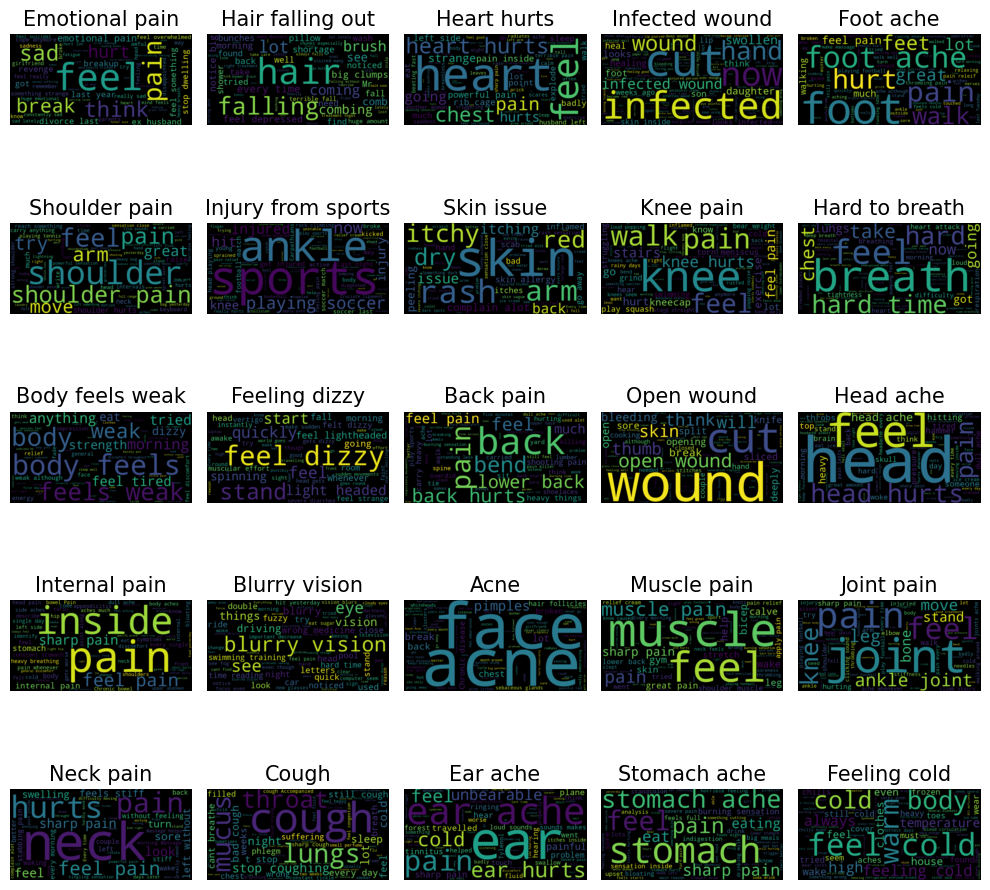

In [7]:
from math import ceil, sqrt

# Combine all the phrases from the training set
phrases = ' '.join(train_df['phrase'])

# Get unique prompts
unique_prompts = train_df['prompt'].unique()

# Calculate the number of rows and columns for the grid
n = len(unique_prompts)
cols = ceil(sqrt(n))
rows = ceil(n / cols)

# Create a figure with subplots
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

for ax, prompt in zip(axs.flatten(), unique_prompts):
    phrases = ' '.join(train_df[train_df['prompt'] == prompt]['phrase'])
    wordcloud = WordCloud(width=800, height=400).generate(phrases)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(prompt, fontsize=15)

# Remove empty subplots
for ax in axs.flatten()[n:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

In [8]:
# create dictionnary to map each prompt to a number
prompt_to_id = {prompt: i for i, prompt in enumerate(record_df.prompt.unique())}
prompt_to_id

{'Emotional pain': 0,
 'Hair falling out': 1,
 'Heart hurts': 2,
 'Infected wound': 3,
 'Foot ache': 4,
 'Shoulder pain': 5,
 'Injury from sports': 6,
 'Skin issue': 7,
 'Stomach ache': 8,
 'Knee pain': 9,
 'Joint pain': 10,
 'Hard to breath': 11,
 'Head ache': 12,
 'Body feels weak': 13,
 'Feeling dizzy': 14,
 'Back pain': 15,
 'Open wound': 16,
 'Internal pain': 17,
 'Blurry vision': 18,
 'Acne': 19,
 'Muscle pain': 20,
 'Neck pain': 21,
 'Cough': 22,
 'Ear ache': 23,
 'Feeling cold': 24}

In [9]:
# create a new column label from the prompt column
record_df["label"] = record_df["prompt"].apply(lambda x: prompt_to_id[x])

record_df.sample(2)

,audio_clipping,audio_clipping:confidence,background_noise_audible,background_noise_audible:confidence,overall_quality_of_the_audio,quiet_speaker,quiet_speaker:confidence,speaker_id,file_download,file_name,phrase,prompt,writer_id,split,label
2858,no_clipping,1.0,light_noise,1.0000,4.0,audible_speaker,1.0,42210938,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_42210938_97618407.wav,I have found some issues in my skin and tried ...,Skin issue,43318517,train,7
5138,no_clipping,1.0,no_noise,0.6812,4.0,audible_speaker,1.0,18386513,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_18386513_32736522.wav,I was kicked in the head playing soccer last n...,Injury from sports,44140394,train,6


In [10]:
record_df.to_csv("./data/record_df.csv", index=False)

### Classification using directly the transformer and not the embeddings


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Device:", device)

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(prompt_to_id)).to(device)

In [ ]:
train_df = record_df[record_df['split'] == 'train']
valid_df = record_df[record_df['split'] == 'validate']
test_df = record_df[record_df['split'] == 'test']

print("Number of training samples: ", len(train_df))
print("Number of validation samples: ", len(valid_df))
print("Number of test samples: ", len(test_df))

In [ ]:
train_encodings = tokenizer(list(train_df['phrase']), truncation=True, padding=True)
val_encodings = tokenizer(list(valid_df['phrase']), truncation=True, padding=True)
test_encodings = tokenizer(list(test_df['phrase']), truncation=True, padding=True)

train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(train_df['label'].values))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(valid_df['label'].values))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']), torch.tensor(test_encodings['attention_mask']), torch.tensor(test_df['label'].values))

batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Set up training parameters
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
epochs = 20


In [ ]:
# Training loop
for epoch in range(epochs):
    model.train()
    for i, batch in enumerate(train_loader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Tr. Loss:  {loss.item()}', end='\r')
        
        
    # Evaluation on the validation set
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += len(labels)

    accuracy = correct / total
    print(f'Epoch: {epoch + 1}, Tr. Loss:  {loss.item()}, Val. Accuracy: {accuracy}')  

In [ ]:
# save the model 
torch.save(model.state_dict(), "./bert.pt")

In [ ]:
# load the model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(prompt_to_id)).to(device)
model.load_state_dict(torch.load("./bert.pt"))

In [ ]:
# Assuming you have a trained model stored in the variable 'model'
model.eval()

# New text for prediction
new_text = "My stomach aches"

# Tokenize the new text
new_text_encoding = tokenizer(new_text, truncation=True, padding=True, return_tensors='pt').to(device)

# Make the prediction
with torch.no_grad():
    output = model(**new_text_encoding)

# Get the predicted class
predicted_class = torch.argmax(output.logits).item()

print(f"Predicted class:  {list(prompt_to_id.keys())[predicted_class]}")

### Second idea : Use the phrase from the metadata


Use a pre trained transformer model to get the embeddings of the phrase 


Create and save the embeddings for the phrases in the metadata


In [15]:
save_path_embedd = "./data/embeddings"
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = BertModel.from_pretrained('bert-large-uncased')

In [16]:
for idx, row in tqdm(record_df.iterrows(), total=len(record_df)):
    # save path for the embedding
    save_path = os.path.join(save_path_embedd, row.split, row.file_name.replace(".wav", ".pt"))
    sentence = row.phrase
    tokenized_text = tokenizer.tokenize(sentence)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    model.eval()
    # Get hidden states
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs.last_hidden_state

    # take the mean of the embeddings over the whole sentence
    sentence_embedding = torch.mean(hidden_states[0], dim=0)
    
    # !! NOTE: we add the label at the end of the embedding (hence 768 for the embedding size and 1 for the label)
    # Also note that for the large bert, the embedding size is 1024 instead of 768
    sentence_embedding_with_label = torch.cat((sentence_embedding, torch.tensor([prompt_to_id[row.prompt]])))
    
    # save the embedding
    torch.save(sentence_embedding_with_label, save_path)

100%|██████████| 6661/6661 [16:19<00:00,  6.80it/s]


In [17]:
def load_embeddings(path):
    embeddings_list = []
    labels_list = []
    for file in tqdm(os.listdir(path)):
        embedding_with_label = torch.load(os.path.join(path, file))
        embedding = embedding_with_label[:-1]
        label = embedding_with_label[-1]
        embeddings_list.append(embedding)
        labels_list.append(label)
    return torch.stack(embeddings_list), torch.stack(labels_list)

train_embeddings, train_labels = load_embeddings(os.path.join(save_path_embedd, "train"))
valid_embeddings, valid_labels = load_embeddings(os.path.join(save_path_embedd, "validate"))
test_embeddings, test_labels = load_embeddings(os.path.join(save_path_embedd, "test"))
print("Train embeddings shape: ", train_embeddings.shape, "Train labels shape: ", train_labels.shape)
print("Valid embeddings shape: ", valid_embeddings.shape, "Valid labels shape: ", valid_labels.shape)
print("Test embeddings shape: ", test_embeddings.shape, "Test labels shape: ", test_labels.shape)

100%|██████████| 381/381 [00:02<00:00, 144.39it/s]

Train embeddings shape:  torch.Size([5895, 1024]) Train labels shape:  torch.Size([5895])
Valid embeddings shape:  torch.Size([385, 1024]) Valid labels shape:  torch.Size([385])
Test embeddings shape:  torch.Size([381, 1024]) Test labels shape:  torch.Size([381])


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = Classifier(train_embeddings.shape[1], len(prompt_to_id)).to(device)	

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.0001)

# Training loop
num_epochs = 5000
train_losses = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    # Training
    classifier.train()
    inputs, targets = train_embeddings.to(device), train_labels.to(device, dtype=torch.long)
    outputs = classifier(inputs)
    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss = loss.item()
    train_losses.append(train_loss)

    classifier.eval()
    with torch.no_grad():
        inputs, targets = valid_embeddings.to(device), valid_labels.to(device, dtype=torch.long)
        outputs = classifier(inputs)
        loss = criterion(outputs, targets)
        valid_loss = loss.item()
        valid_losses.append(valid_loss)
        accuracy = torch.mean((torch.argmax(outputs, dim=1) == targets).float())
        valid_accs.append(accuracy.item())

    if epoch % 50 == 0:
        print("Epoch:", "%04d" % (epoch + 1), "train cost =", "{:.6f}".format(train_loss), "valid cost =", "{:.6f}".format(valid_loss), "valid accuracy =", "{:.2f}".format(accuracy * 100.0))

# use the test set to evaluate the model
classifier.eval()
with torch.no_grad():
    inputs, targets = test_embeddings.to(device), test_labels.to(device, dtype=torch.long)
    outputs = classifier(inputs)
    loss = criterion(outputs, targets)
    test_acc = torch.mean((torch.argmax(outputs, dim=1) == targets).float())
    print("Test accuracy: ", test_acc.item())


import numpy as np

# save the losses and accuracies as numpy arrays
np.save("./results/embeddings/test_acc.npy", np.array(test_acc.item()))
np.save("./results/embeddings/tr_losses.npy", np.array(train_losses))
np.save("./results/embeddings/val_accs.npy", np.array(valid_accs))
np.save("./results/embeddings/val_losses.npy", np.array(valid_losses))


Epoch: 0001 train cost = 3.224530 valid cost = 3.214903 valid accuracy = 3.38
Epoch: 0051 train cost = 3.051791 valid cost = 3.056455 valid accuracy = 24.16
Epoch: 0101 train cost = 2.803746 valid cost = 2.818522 valid accuracy = 39.22
Epoch: 0151 train cost = 2.520890 valid cost = 2.542976 valid accuracy = 54.55
Epoch: 0201 train cost = 2.231277 valid cost = 2.256699 valid accuracy = 62.34
Epoch: 0251 train cost = 1.950100 valid cost = 1.977751 valid accuracy = 70.39
Epoch: 0301 train cost = 1.687835 valid cost = 1.716816 valid accuracy = 76.36
Epoch: 0351 train cost = 1.449469 valid cost = 1.478699 valid accuracy = 81.30
Epoch: 0401 train cost = 1.237301 valid cost = 1.265969 valid accuracy = 87.01
Epoch: 0451 train cost = 1.051676 valid cost = 1.079002 valid accuracy = 88.57
Epoch: 0501 train cost = 0.891585 valid cost = 0.917066 valid accuracy = 92.47
Epoch: 0551 train cost = 0.755026 valid cost = 0.777990 valid accuracy = 93.51
Epoch: 0601 train cost = 0.639440 valid cost = 0.6594

Test accuracy:  0.9973753094673157


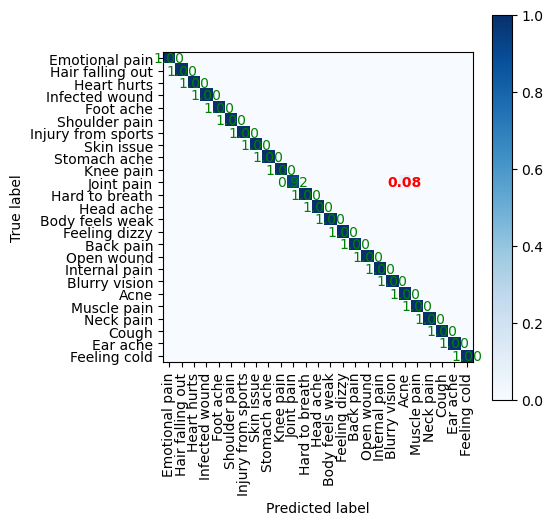

In [19]:
# create confusion matrix for the tets set 
classifier.eval()
with torch.no_grad():
    inputs, targets = test_embeddings.to(device), test_labels.to(device, dtype=torch.long)
    outputs = classifier(inputs)
    predictions = torch.argmax(outputs, dim=1)
    accuracy = torch.mean((predictions == targets).float())
    print("Test accuracy: ", accuracy.item())

    # Create confusion matrix
    confusion_matrix = torch.zeros(len(prompt_to_id), len(prompt_to_id))
    for t, p in zip(targets, predictions):
        confusion_matrix[t, p] += 1

    # Normalize confusion matrix
    confusion_matrix = confusion_matrix / confusion_matrix.sum(dim=1, keepdim=True)

    # Create a figure
    plt.figure(figsize=(5, 5))
    # Show confusion matrix
    plt.imshow(confusion_matrix, cmap='Blues')
    plt.xticks(range(len(prompt_to_id)), prompt_to_id.keys(), rotation=90)
    plt.yticks(range(len(prompt_to_id)), prompt_to_id.keys())
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.colorbar()

    # Add text annotations for non-zero misclassified data
    for i in range(len(prompt_to_id)):
        for j in range(len(prompt_to_id)):
            value = confusion_matrix[i, j]
            if value != 0:
                text = plt.text(j, i, f'{value:.2f}', ha='center', va='center', color='green')
                # Highlight misclassified data
                if i != j:
                    text.set_color("red")
                    text.set_weight('bold')

    plt.show()

In [ ]:
# test the model where you can input a live audio recording
sentence1 = speech_to_text()
print("You said: ", sentence1)
sentence2 = speech_to_text()
print("You said: ", sentence2)
sentences = [sentence1, sentence2]
acc = 0 
labels = prompt_to_id.values()
for sentence, label in zip(sentences, labels):
    tokenized_text = tokenizer.tokenize(sentence)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    model.eval()
    # Get hidden states
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs.last_hidden_state

    # take the mean of the embeddings over the whole sentence
    sentence_embedding = torch.mean(hidden_states[0], dim=0)

    # classify the sentence
    classifier.eval()
    with torch.no_grad():
        inputs = sentence_embedding.to(device)
        inputs = inputs.unsqueeze(0)
        outputs = classifier(inputs)
        prediction = torch.argmax(outputs, dim=1)
        predicted_prompt = list(prompt_to_id.keys())[prediction.item()]
     
    # print("Label: ", label)
    print("Predicted prompt: ", predicted_prompt)
    print("--------------------------------------------------")
    print("\n")
    # acc += label == predicted_prompt
    
# print("Accuracy: ", acc / len(sentences), " %")

### Compare both 


### Use a combination of both
